### 依赖包导入

In [1]:
import argparse
import os
import random
from datetime import datetime
from IPython.display import Image, display

import numpy as np
import torch
import torch.distributed as dist

from exp.exp_forecast import Exp_Forecast
from exp.exp_anomaly_detection import Exp_Anomaly_Detection
from exp.exp_imputation import Exp_Imputation
from utils.tools import HiddenPrints

### 变量定义

In [3]:
args = argparse.Namespace(
    # ===== basic config =====
    task_name="anomaly_detection",
    model_id="Timer_multivariate_anomaly_detection",
    model="Timer_multivariate",
    seed=42,

    # ===== data loader =====
    data="multivariate_anomaly",
    root_path="./dataset/xw/elec",
    data_path="ETTh1.csv",
    features="M",
    target="OT",
    freq="h",
    checkpoints="./checkpoints/",
    inverse=False,

    # ===== model define =====
    d_model=256,
    n_heads=8,
    e_layers=4,
    d_layers=1,
    d_ff=512,
    factor=1,
    distil=True,
    dropout=0.1,
    embed="timeF",
    activation="gelu",
    output_attention=False,
    use_norm=True,
    max_len=10000,
    mask_flag=True,
    binary_bias=False,
    covariate=True,
    n_pred_vars=15,
    freeze_layer=False,

    # ===== optimization =====
    num_workers=10,
    itr=1,
    train_epochs=10,
    batch_size=64,
    patience=3,
    learning_rate=1e-4,
    des="test",
    loss="MSE",
    lradj="type1",
    use_amp=False,

    # ===== GPU =====
    use_gpu=True,
    gpu=0,
    use_multi_gpu=False,
    devices="0,1,2,3",

    # ===== misc =====
    stride=1,
    ckpt_path="checkpoints/Timer_anomaly_detection_1.0.ckpt",
    finetune_epochs=10,
    finetune_rate=0.1,
    local_rank=0,

    patch_len=96,
    subset_rand_ratio=1.0,
    data_type="custom",

    decay_fac=0.75,

    # ===== cosine decay =====
    cos_warm_up_steps=100,
    cos_max_decay_steps=60000,
    cos_max_decay_epoch=10,
    cos_max=1e-4,
    cos_min=2e-6,

    # ===== weight decay =====
    use_weight_decay=0,
    weight_decay=0.01,

    # ===== autoregressive configs =====
    use_ims=True,
    output_len=96,
    output_len_list=None,

    # ===== train_test =====
    train_test=0,
    valid_ratio=0.2,
    is_finetuning=1,
    test_dir="test_results",
    test_version="test",  # 可选 "test", "predict", "prune", "visualize"
    prune_ratio=0.2,
    remove_mask=False,

    # ===== forecasting task =====
    seq_len=768,
    label_len=48,
    pred_len=96,
    input_len=96,

    # ===== imputation task =====
    mask_rate=0.25,

    # ===== anomaly detection task =====
    loss_threshold=10.0,

    # ===== opacus options =====
    use_opacus=False,
    noise_multiplier=1.1,
    max_grad_norm=1.0,

    # ===== training info visualize configs =====
    record_info=False,
)

fix_seed = args.seed
random.seed(fix_seed)
torch.manual_seed(fix_seed)
np.random.seed(fix_seed)
args.use_gpu = True if torch.cuda.is_available() and args.use_gpu else False
if args.use_multi_gpu:
    ip = os.environ.get("MASTER_ADDR", "127.0.0.1")
    port = os.environ.get("MASTER_PORT", "64209")
    hosts = int(os.environ.get("WORLD_SIZE", "8"))  # number of nodes
    rank = int(os.environ.get("RANK", "0"))  # node id
    local_rank = int(os.environ.get("LOCAL_RANK", "0"))
    gpus = torch.cuda.device_count()  # gpus per node
    args.local_rank = local_rank
    print(
        'ip: {}, port: {}, hosts: {}, rank: {}, local_rank: {}, gpus: {}'.format(ip, port, hosts, rank, local_rank,
                                                                                    gpus))
    dist.init_process_group(backend="nccl", init_method=f"tcp://{ip}:{port}", world_size=hosts, rank=rank)
    print('init_process_group finished')
    torch.cuda.set_device(local_rank)

### 训练数据读取

In [7]:
with HiddenPrints(int(os.environ.get("LOCAL_RANK", "0"))):
    # setting record of experiments
    setting = f"{args.model}_{args.task_name}_{args.data}_d{args.d_model}_n{args.n_heads}_l{args.e_layers}_itr0_"
    setting += datetime.now().strftime("%y-%m-%d_%H-%M-%S")

    print(f"checkpoints folder are $root/checkpoints/{setting}.")
    print(f"test_results folder are $root/test_results/{setting}.")
    
    exp = Exp_Anomaly_Detection(args)  # set experiments
    trainset, trainloader = exp._get_data(flag="train")
    print(f"Number of samples in trainset: {len(trainset)}")
    print(f"Number of batches in trainloader: {len(trainloader)}")
    first_sample = trainset[0]
    print("First sample in trainset:", first_sample)


checkpoints folder are $root/checkpoints/Timer_multivariate_anomaly_detection_multivariate_anomaly_d256_n8_l4_itr0_25-09-07_16-59-00.
test_results folder are $root/test_results/Timer_multivariate_anomaly_detection_multivariate_anomaly_d256_n8_l4_itr0_25-09-07_16-59-00.
Use GPU: cuda:0
Number of samples in trainset: 272
Number of batches in trainloader: 5
First sample in trainset: [[  0   0   0 ...   0   0   0]
 [  1   1   1 ...   1   1   1]
 [  2   2   2 ...   2   2   2]
 ...
 [765 765 765 ... 765 765 765]
 [766 766 766 ... 766 766 766]
 [767 767 767 ... 767 767 767]]


### 模型训练

In [4]:
with HiddenPrints(int(os.environ.get("LOCAL_RANK", "0"))):
    print('>>>>>>>start training : {}>>>>>>>>>>>>>>>>>>>>>>>>>>'.format(setting))
    exp.finetune(setting)

>>>>>>>start training : Timer_multivariate_anomaly_detection_multivariate_anomaly_d256_n8_l4_itr0_25-09-07_16-47-43>>>>>>>>>>>>>>>>>>>>>>>>>>
train steps per epoch: 5
Epoch: 1 cost time: 5.019757986068726
Epoch: 1, Steps: 5 | Train Loss: 43764.3093750 Vali Loss: 28524.4746094
Validation loss decreased (inf --> 28524.474609).  Saving model ...
Updating learning rate to 0.0001
Epoch: 2 cost time: 0.988797664642334
Epoch: 2, Steps: 5 | Train Loss: 25775.9738281 Vali Loss: 16855.4785156
Validation loss decreased (28524.474609 --> 16855.478516).  Saving model ...
Updating learning rate to 5e-05
Epoch: 3 cost time: 0.9845714569091797
Epoch: 3, Steps: 5 | Train Loss: 17668.7078125 Vali Loss: 13245.5869141
Validation loss decreased (16855.478516 --> 13245.586914).  Saving model ...
Updating learning rate to 2.5e-05
Epoch: 4 cost time: 0.9728877544403076
Epoch: 4, Steps: 5 | Train Loss: 14839.4644531 Vali Loss: 11812.5869141
Validation loss decreased (13245.586914 --> 11812.586914).  Saving mod

### 测试数据生成和异常数据保存（可选，如需要请取消注释代码，保存位置在checkpoints保存位置的文件夹下）

In [5]:
with HiddenPrints(int(os.environ.get("LOCAL_RANK", "0"))):
    print('>>>>>>>testing : {}<<<<<<<<<<<<<<<<<<<<<<<<<<<<<<<<<'.format(setting))
    filename_list = os.listdir(os.path.join(args.root_path, "test"))
    for filename in filename_list:
        args.data_path = filename
        print(f"-------testing : {filename}-------")
        anomaly_dataset, _ = exp._gen_manual_anomaly_patch(k=5)
        tensor = anomaly_dataset.tensors[0] if hasattr(anomaly_dataset, "tensors") else anomaly_dataset.tensor
        # 保存为 PyTorch 二进制文件
        # torch.save(tensor, os.path.join(args.checkpoints, setting, f"{filename}.pt"))
        torch.cuda.empty_cache()
print(anomaly_dataset[0])

>>>>>>>testing : Timer_multivariate_anomaly_detection_multivariate_anomaly_d256_n8_l4_itr0_25-09-07_16-47-43<<<<<<<<<<<<<<<<<<<<<<<<<<<<<<<<<
-------testing : test.csv-------
(tensor([[  0.,   0.,   0.,  ...,   0.,   0.,   0.],
        [  1.,   1.,   1.,  ...,   1.,   1.,   1.],
        [  2.,   2.,   2.,  ...,   2.,   2.,   2.],
        ...,
        [765., 765., 765.,  ..., 765., 765., 765.],
        [766., 766., 766.,  ..., 766., 766., 766.],
        [767., 767., 767.,  ..., 767., 767., 767.]]),)


### 模型测试

In [6]:
with HiddenPrints(int(os.environ.get("LOCAL_RANK", "0"))):
    print('>>>>>>>testing : {}<<<<<<<<<<<<<<<<<<<<<<<<<<<<<<<<<'.format(setting))
    filename_list = os.listdir(os.path.join(args.root_path, "test"))
    for filename in filename_list:
        args.data_path = filename
        print(f"-------testing : {filename}-------")
        exp.test(setting)
        torch.cuda.empty_cache()

>>>>>>>testing : Timer_multivariate_anomaly_detection_multivariate_anomaly_d256_n8_l4_itr0_25-09-07_16-47-43<<<<<<<<<<<<<<<<<<<<<<<<<<<<<<<<<
-------testing : test.csv-------
Model parameters:  2158176


In [ ]:
test_result_dir = os.path.join(args.test_dir, setting, "test")
image_path_list = [f for f in os.listdir(test_result_dir) if f.endswith('.png')]
for idx, image_path in enumerate(image_path_list):
    print(f"{idx}: {image_path}")

0: feat_13_of_test_data_('test', '.csv').png
1: feat_12_of_test_data_('test', '.csv').png
2: feat_2_of_test_data_('test', '.csv').png
3: feat_6_of_test_data_('test', '.csv').png
4: feat_15_of_test_data_('test', '.csv').png
5: feat_9_of_test_data_('test', '.csv').png
6: feat_7_of_test_data_('test', '.csv').png
7: feat_11_of_test_data_('test', '.csv').png
8: feat_5_of_test_data_('test', '.csv').png
9: feat_4_of_test_data_('test', '.csv').png
10: feat_14_of_test_data_('test', '.csv').png
11: feat_1_of_test_data_('test', '.csv').png
12: feat_3_of_test_data_('test', '.csv').png
13: feat_10_of_test_data_('test', '.csv').png
14: feat_8_of_test_data_('test', '.csv').png


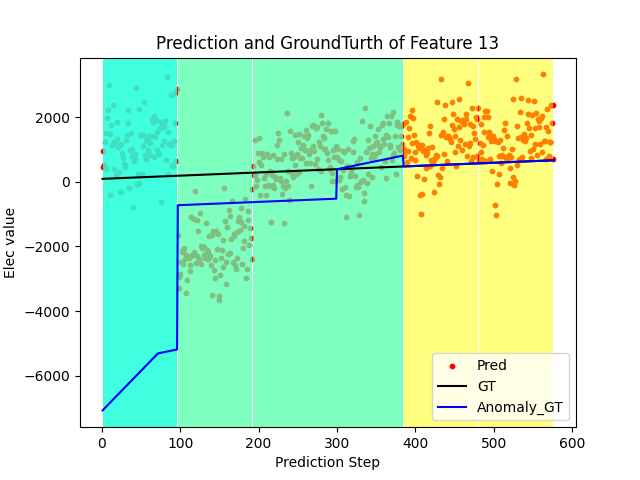

In [9]:
default_image_idx = 0
display(Image(filename=os.path.join(test_result_dir, image_path_list[default_image_idx])))